In [1]:
import os
import sys
import logging
import datetime
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sys.path.insert(1, r'methods')

from data_methods import getData, standardize
# from dimensionality_reduction import reduce_dimensionality,reduce_with
# from beamSearch import EMM, as_string
# from adjPysubgroup import adjustedBestFirstSearch, adjustedDFS, adjustedApriori
from qualityMeasures import calc_result_bs, calc_result_ps
from interpretabilityMeasures import Feature_Correlation_Scores, DBI_beam, DBI_ps

In [ ]:
sd_methods = ['Beam Search', 'Depth-First Search', 'Best-First Search', 'Apriori']
output_dataframes = {}
for sd_method in sd_methods:
    print(sd_method, ":    \n\n")
    sd_results_path = r'C:\Users\20193723\OneDrive - TU Eindhoven\Documents\Research Topics in Data Mining\Interpretable-Subgroup-Discovery\results_renamed'
    dct_datasets = ['Ionosphere', 'Arrhythmia', 'Indoor', 'Soybean', 'Mushroom', 'Adult']  # to test <- Remove later
    categorical_datasets = ['Mushroom', 'Adult']
    quality_results = []
    quality_results_columns = []
    for dataset in dct_datasets:
        dataset_quality_results = []
        dataset_quality_columns = []
        #Load dataframes and results
        df_file_name = dataset+'-data-reductions.pkl'
        results_file_name = dataset+'-results.pkl'
        with open(os.path.join(sd_results_path,df_file_name), 'rb') as f:
            dfs_dict =pickle.load(f)
        with open(os.path.join(sd_results_path,results_file_name), 'rb') as f:
            results_dict =pickle.load(f)
        
        if sd_method == 'Beam Search':
            print(dataset, ":    \n")
            en_methods = ['auto_encoder', 'PCA', 'SPCA']
            subgroups_beam_en = [i for i in results_dict['auto_encoder'][sd_method]['results_org'].get_values()]
            subgroups_beam = [i for i in results_dict['vanilla'][sd_method]['results_org'].get_values()]
            output_en, output = calc_result_bs(dfs_dict['auto_encoder'], dfs_dict['vanilla'], subgroups_beam_en, subgroups_beam)
            dataset_quality_results+=output
            dataset_quality_columns += ['coverage', 'coverage_prop', 'avg_size', 'max_wracc', 'avg_wracc']
            for en_method in en_methods:
                print(en_method)
                subgroups_beam_en = [i for i in results_dict[en_method][sd_method]['results_org'].get_values()]
                subgroups_beam = [i for i in results_dict['vanilla'][sd_method]['results_org'].get_values()]
                output_en, output = calc_result_bs(dfs_dict[en_method], dfs_dict['vanilla'], subgroups_beam_en, subgroups_beam)
                dataset_quality_results+=output_en
                dataset_quality_columns += ['coverage_'+en_method, 'coverage_pop_'+en_method, 'added_'+en_method, 'added_prop_'+en_method, 'removed_'+en_method, 'removed_prop_'+en_method, 'avg_size_'+en_method, 'max_wracc_'+en_method, 'avg_wracc_'+en_method]
        
        
        if sd_method != 'Beam Search':
            print(dataset, ":    \n")
            en_methods = ['auto_encoder', 'PCA', 'SPCA']
            output_en, output = calc_result_ps(dfs_dict['auto_encoder'], dfs_dict['vanilla'], results_dict['auto_encoder'][sd_method]['results_org'], results_dict['vanilla'][sd_method]['results_org'])
            dataset_quality_results+=output
            dataset_quality_columns += ['coverage', 'coverage_prop', 'avg_size', 'max_wracc', 'avg_wracc']
            for en_method in en_methods:
                print(en_method)
                output_en, output = calc_result_ps(dfs_dict[en_method], dfs_dict['vanilla'], results_dict[en_method][sd_method]['results_org'], results_dict['vanilla'][sd_method]['results_org'])
                dataset_quality_results+=output_en
                dataset_quality_columns += ['coverage_'+en_method, 'coverage_pop_'+en_method, 'added_'+en_method, 'added_prop_'+en_method, 'removed_'+en_method, 'removed_prop_'+en_method, 'avg_size_'+en_method, 'max_wracc_'+en_method, 'avg_wracc_'+en_method]
        
        quality_results.append(dataset_quality_results)
    df = pd.DataFrame(data=quality_results, index=dct_datasets, columns=dataset_quality_columns)
    output_dataframes[sd_method] = df

In [ ]:
sd_methods = ['Beam Search', 'Depth-First Search', 'Best-First Search', 'Apriori']
for sd_method in sd_methods:
    output_dataframes[sd_method].to_csv(f"final_results/subgroup results {sd_method}.csv")

In [ ]:
sd_results_path = r'C:\Users\20193723\OneDrive - TU Eindhoven\Documents\Research Topics in Data Mining\Interpretable-Subgroup-Discovery\results_renamed'
dct_datasets = ['Ionosphere', 'Arrhythmia', 'Indoor', 'Soybean', 'Mushroom', 'Adult'] 
categorical_datasets = ['Mushroom', 'Adult']
for dataset in dct_datasets:
    #Load dataframes and results
    df_file_name = dataset+'-data-reductions.pkl'
    results_file_name = dataset+'-results.pkl'
    with open(os.path.join(sd_results_path,df_file_name), 'rb') as f:
        dfs_dict =pickle.load(f)
    with open(os.path.join(sd_results_path,results_file_name), 'rb') as f:
        results_dict =pickle.load(f)
    #One-hot encode vanilla dataframe if categorical
    original_df = dfs_dict['vanilla']
    if dataset in categorical_datasets:
       features = [i for i in original_df.columns if i !='target']
       OHenc = OneHotEncoder() 
       dataCategorical = OHenc.fit_transform(original_df[features]).toarray()
       original_df = pd.DataFrame(dataCategorical)
    #Compute and print scores and index
    print(dataset, ":    \n")
    en_methods = ['auto_encoder', 'PCA', 'SPCA']
    ps_sd_methods = ['Apriori', 'Best-First Search', 'Depth-First Search']
    for en_method in en_methods:
        fcs, fcss = Feature_Correlation_Scores(original_df, dfs_dict[en_method])
        print(en_method, ":    ", "\n   FCS: ", round(fcs, 2), "    FCSS", round(fcss, 2))
        for sd_method in ps_sd_methods:
            dbi = DBI_ps(results_dict[en_method][sd_method]['results_org'], dfs_dict[en_method])
            print("DBI "+sd_method+": ", dbi)
        subgroups_beam = [i for i in results_dict[en_method]['Beam Search']['results_org'].get_values()]
        dbi = DBI_beam(subgroups_beam, dfs_dict[en_method])
        print("DBI Beam Search: ", dbi, "\n")
    print("\n\n")

In [3]:
# Loading the object using dill
sd_results_path = r'C:\Users\20193723\OneDrive - TU Eindhoven\Documents\Research Topics in Data Mining\Interpretable-Subgroup-Discovery\sd_results'
file_name = 'Ionosphere-data-reductions.pkl'
with open(os.path.join(sd_results_path,file_name), 'rb') as f:
    dfs_dict =pickle.load(f)

In [4]:
# datasets = []
# for dataset in dataset:
#     file_name = '-data-reductions.pkl'
#     en_methods = ['vanilla', 'auto_encoder', 'PCA', 'SPCA']
#     for en_method in en_methods:
#         fcs, fcss = Feature_Correlation_Scores(loaded_dict['vanilla'], loaded_dict[en_method])
#         print(en_method, "    ", "\n FCS: ", round(fcs, 2), "    FCSS", round(fcss, 2))

In [15]:
en_methods = ['auto_encoder', 'PCA', 'SPCA']
for en_method in en_methods:
    fcs, fcss = Feature_Correlation_Scores(dfs_dict['vanilla'], dfs_dict[en_method])
    print(en_method, "    ", "\n FCS: ", round(fcs, 2), "    FCSS", round(fcss, 2))

auto_encoder      
 FCS:  0.59     FCSS 0.12
PCA      
 FCS:  0.65     FCSS 0.14
SPCA      
 FCS:  0.72     FCSS 0.19


In [3]:
sd_results_path = r'C:\Users\20193723\OneDrive - TU Eindhoven\Documents\Research Topics in Data Mining\Interpretable-Subgroup-Discovery\results_renamed'
file_name = 'Soybean-results.pkl'
with open(os.path.join(sd_results_path,file_name), 'rb') as f:
    results_dict =pickle.load(f)

In [16]:
bfs = results_dict['vanilla']['Best-First Search']['results_org']
bfs_en = results_dict['PCA']['Best-First Search']['results_org']

In [17]:
vanilla = results_dict['auto_encoder']['Beam Search']['results_org']

In [18]:
subgroups_n = [i for i in vanilla.get_values()]

In [21]:
df = dfs_dict['auto_encoder']

In [22]:
df[df.eval(str(subgroups_n[1][1]).replace("', '", ' and ').replace("['", '').replace("']", ''))]

,target,cat1,cat2,cat3,cat4,cat5
36,0,2.670305,-0.637574,-0.008092,0.009340,1.814592
398,0,2.418383,-0.990442,-0.221028,0.080094,1.067282
513,0,3.184095,-1.293544,-0.379369,0.241604,2.213722
588,0,2.885142,-0.685566,-0.218985,0.358690,1.813227
632,0,-0.679030,-0.816299,-0.315998,0.162555,0.262455
...,...,...,...,...,...,...
8118,1,1.369584,-0.718166,1.165795,0.577131,-0.751188
8119,0,-0.775223,1.175854,-0.006725,2.146407,1.737964
8121,0,-1.062942,0.916443,0.504892,2.226397,2.688123
8122,1,1.088449,-0.264263,0.256847,1.536109,0.332227


In [47]:
str(subgroups_n[1][1])

"['cat2 > -0.8140837550163269', 'cat2 <= -0.17320257425308228']"

In [5]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
original_df = dfs_dict['vanilla']
features = [i for i in original_df.columns if i !='target']

In [6]:
OHenc = OneHotEncoder() 
dataCategorical = OHenc.fit_transform(original_df[features]).toarray()
original_encoded = pd.DataFrame(dataCategorical)

In [31]:
subgroups = results_dict['auto_encoder']['Best-First Search']['results_org']
subgroups
# subgroups[subgroups['relative_size_sg'] >= 0.5]

,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.060476,cat5<304.81,84,420,62,183,336,0.200000,0.800000,0.338798,0.661202,0.738095,0.360119,0.435714,1.693989
1,0.043810,cat4>=100.28,84,420,55,183,336,0.200000,0.800000,0.300546,0.699454,0.654762,0.380952,0.435714,1.502732
2,0.039048,cat2>=79.74,84,420,53,183,336,0.200000,0.800000,0.289617,0.710383,0.630952,0.386905,0.435714,1.448087
3,0.036667,cat1>=210.55,84,420,52,183,336,0.200000,0.800000,0.284153,0.715847,0.619048,0.389881,0.435714,1.420765
4,0.036037,cat2>=79.74 AND cat5<304.81,41,420,33,183,379,0.097619,0.902381,0.180328,0.819672,0.804878,0.395778,0.435714,1.847261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000561,cat4: [29.65:100.28[ AND cat5>=404.84,27,420,12,183,393,0.064286,0.935714,0.065574,0.934426,0.444444,0.435115,0.435714,1.020036
96,0.000493,cat1: [92.89:142.86[ AND cat4: [-41.07:-8.42[,11,420,5,183,409,0.026190,0.973810,0.027322,0.972678,0.454545,0.435208,0.435714,1.043219
97,0.000374,cat1: [92.89:142.86[ AND cat4>=100.28,18,420,8,183,402,0.042857,0.957143,0.043716,0.956284,0.444444,0.435323,0.435714,1.020036
98,0.000374,cat2<-21.22 AND cat4: [-41.07:-8.42[,18,420,8,183,402,0.042857,0.957143,0.043716,0.956284,0.444444,0.435323,0.435714,1.020036


In [23]:
sd_results_path = r'C:\Users\20193723\OneDrive - TU Eindhoven\Documents\Research Topics in Data Mining\Interpretable-Subgroup-Discovery\results_renamed'
dct_datasets = ['Arrhythmia'] # to test <- Remove later
categorical_datasets = ['Mushroom', 'Adult']
for dataset in dct_datasets:
    #Load dataframes and results
    df_file_name = dataset+'-data-reductions.pkl'
    results_file_name = dataset+'-results.pkl'
    with open(os.path.join(sd_results_path,df_file_name), 'rb') as f:
        dfs_dict =pickle.load(f)
    with open(os.path.join(sd_results_path,results_file_name), 'rb') as f:
        results_dict =pickle.load(f)
    #One-hot encode vanilla dataframe if categorical
    original_df = dfs_dict['vanilla']
    if dataset in categorical_datasets:
       features = [i for i in original_df.columns if i !='target']
       OHenc = OneHotEncoder() 
       dataCategorical = OHenc.fit_transform(original_df[features]).toarray()
       original_df = pd.DataFrame(dataCategorical)
    #Compute and print scores and index
    print(dataset, ":    \n")
    en_methods = ['auto_encoder', 'PCA', 'SPCA']
    ps_sd_methods = ['Apriori', 'Best-First Search', 'Depth-First Search']
    for en_method in en_methods:
        fcs, fcss = Feature_Correlation_Scores(original_df, dfs_dict[en_method])
        print(en_method, ":    ", "\n   FCS: ", round(fcs, 2), "    FCSS", round(fcss, 2))
        for sd_method in ps_sd_methods:
            dbi = DBI_ps(results_dict[en_method][sd_method]['results_org'], dfs_dict[en_method])
            print("DBI "+sd_method+": ", dbi)
        subgroups_beam = [i for i in results_dict[en_method]['Beam Search']['results_org'].get_values()]
        dbi = DBI_beam(subgroups_beam, dfs_dict[en_method])
        print("DBI Beam Search: ", dbi, "\n")
    print("\n\n")

Arrhythmia :    

auto_encoder :     
   FCS:  0.7     FCSS 0.31
DBI Apriori:  176.04204264686868
DBI Best-First Search:  185.5963747531536
DBI Depth-First Search:  184.90905777288822
DBI Beam Search:  1.2806238656859177e+18 

PCA :     
   FCS:  0.76     FCSS 0.25
DBI Apriori:  9.128979268086724
DBI Best-First Search:  8.782523375745633


UndefinedVariableError: name 'Dataset' is not defined

In [3]:
sd_results_path = r'C:\Users\20193723\OneDrive - TU Eindhoven\Documents\Research Topics in Data Mining\Interpretable-Subgroup-Discovery\results_renamed'
dct_datasets = ['Ionosphere', 'Arrhythmia', 'Indoor', 'Soybean', 'Mushroom', 'Adult'] 
categorical_datasets = ['Mushroom', 'Adult']
for dataset in dct_datasets:
    #Load dataframes and results
    df_file_name = dataset+'-data-reductions.pkl'
    results_file_name = dataset+'-results.pkl'
    with open(os.path.join(sd_results_path,df_file_name), 'rb') as f:
        dfs_dict =pickle.load(f)
    with open(os.path.join(sd_results_path,results_file_name), 'rb') as f:
        results_dict =pickle.load(f)
    #One-hot encode vanilla dataframe if categorical
    original_df = dfs_dict['vanilla']
    if dataset in categorical_datasets:
       features = [i for i in original_df.columns if i !='target']
       OHenc = OneHotEncoder() 
       dataCategorical = OHenc.fit_transform(original_df[features]).toarray()
       original_df = pd.DataFrame(dataCategorical)
    #Compute and print scores and index
    print(dataset, ":    \n")
    en_methods = ['auto_encoder', 'PCA', 'SPCA']
    ps_sd_methods = ['Apriori', 'Best-First Search', 'Depth-First Search']
    for en_method in en_methods:
        fcs, fcss = Feature_Correlation_Scores(original_df, dfs_dict[en_method])
        print(en_method, ":    ", "\n   FCS: ", round(fcs, 2), "    FCSS", round(fcss, 2))
        for sd_method in ps_sd_methods:
            dbi = DBI_ps(results_dict[en_method][sd_method]['results_org'], dfs_dict[en_method])
            print("DBI "+sd_method+": ", dbi)
        subgroups_beam = [i for i in results_dict[en_method]['Beam Search']['results_org'].get_values()]
        dbi = DBI_beam(subgroups_beam, dfs_dict[en_method])
        print("DBI Beam Search: ", dbi, "\n")
    print("\n\n")

Ionosphere :    

auto_encoder :     
   FCS:  0.59     FCSS 0.12
DBI Apriori:  4.646945864519912
DBI Best-First Search:  5.07139943290663


KeyboardInterrupt: 

In [4]:
output_dataframes['Beam Search']

,coverage,coverage_prop,avg_size,max_wracc,avg_wracc,coverage_auto_encoder,coverage_pop_auto_encoder,added_auto_encoder,added_prop_auto_encoder,removed_auto_encoder,...,avg_wracc_PCA,coverage_SPCA,coverage_pop_SPCA,added_SPCA,added_prop_SPCA,removed_SPCA,removed_prop_SPCA,avg_size_SPCA,max_wracc_SPCA,avg_wracc_SPCA
Ionosphere,301,0.857550,184.63,0.140770,0.131645,263,0.749288,15,0.042735,53,...,0.138172,270,0.769231,12,0.034188,43,0.122507,187.33,0.117978,0.104207
Arrhythmia,187,0.445238,146.36,0.082789,0.080854,221,0.526190,119,0.283333,85,...,0.061799,210,0.500000,68,0.161905,45,0.107143,104.12,0.090476,0.066294
Indoor,5553,0.263826,4235.05,0.108034,0.107908,13094,0.622102,7574,0.359844,33,...,0.208759,14450,0.686526,8898,0.422748,1,0.000048,7798.87,0.214514,0.179918
Soybean,266,1.000000,266.00,0.000000,0.000000,169,0.635338,0,0.000000,97,...,0.163007,152,0.571429,0,0.000000,114,0.428571,91.01,0.203742,0.169103
Mushroom,4596,0.565731,4018.08,0.242026,0.226013,4429,0.545175,1218,0.149926,1385,...,0.160968,4485,0.552068,1046,0.128754,1157,0.142418,2844.20,0.194271,0.167028


In [7]:
output_dataframes['Beam Search'].to_csv(f"subgroup_final_results/subgroup results {sd_method}.csv")

Beam Search :    


Ionosphere :    

coverage autoencoding: 263, (0.7492877492877493)
coverage no auto encoding: 301, (0.8575498575498576)
# rows added in subgroups: 15 (0.042735042735042736)
# rows no longer in subgroups: 53, (0.150997150997151)
average subgroup size auto encoded: 162.5
average subgroup size no auto encoding: 184.63
WRACC auto encoding: Max: 0.11220688143765066, Mean: 0.09886989553656217
WRACC no auto encoding: Max: 0.1407699612827818, Mean: 0.13164511651691138


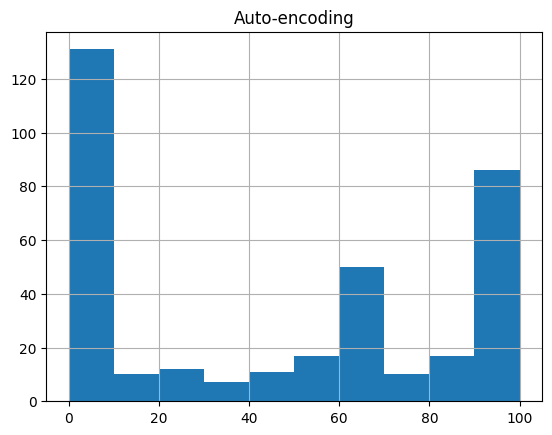

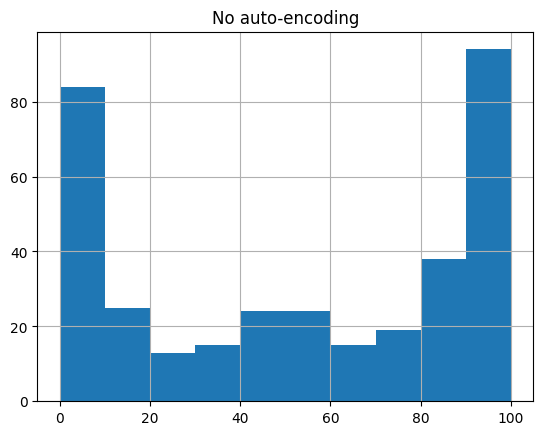

auto_encoder
coverage autoencoding: 263, (0.7492877492877493)
coverage no auto encoding: 301, (0.8575498575498576)
# rows added in subgroups: 15 (0.042735042735042736)
# rows no longer in subgroups: 53, (0.150997150997151)
average subgroup size auto encoded: 162.5
average subgroup size no auto encoding: 184.63
WRACC auto encoding: Max: 0.11220688143765066, Mean: 0.09886989553656217
WRACC no auto encoding: Max: 0.1407699612827818, Mean: 0.13164511651691138


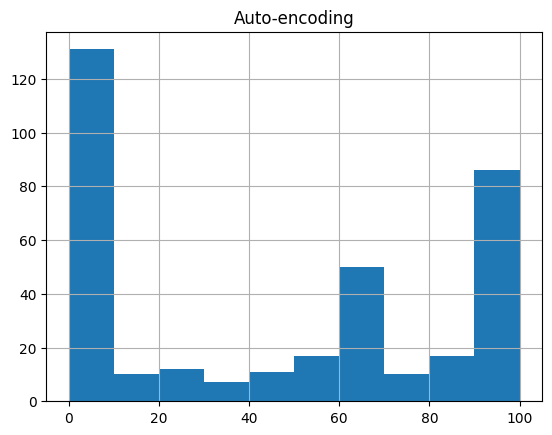

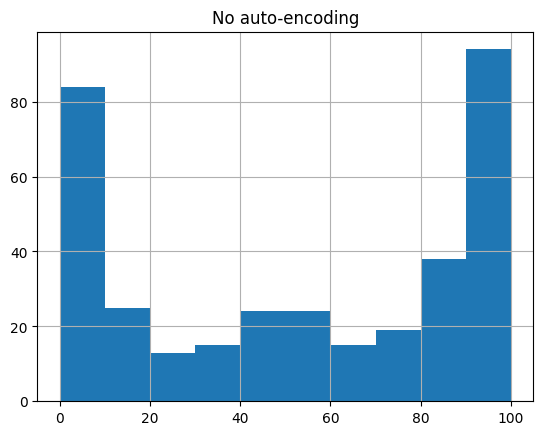

PCA
coverage autoencoding: 265, (0.7549857549857549)
coverage no auto encoding: 301, (0.8575498575498576)
# rows added in subgroups: 6 (0.017094017094017096)
# rows no longer in subgroups: 42, (0.11965811965811966)
average subgroup size auto encoded: 197.67
average subgroup size no auto encoding: 184.63
WRACC auto encoding: Max: 0.1538461538461538, Mean: 0.13817225509533196
WRACC no auto encoding: Max: 0.1407699612827818, Mean: 0.13164511651691138


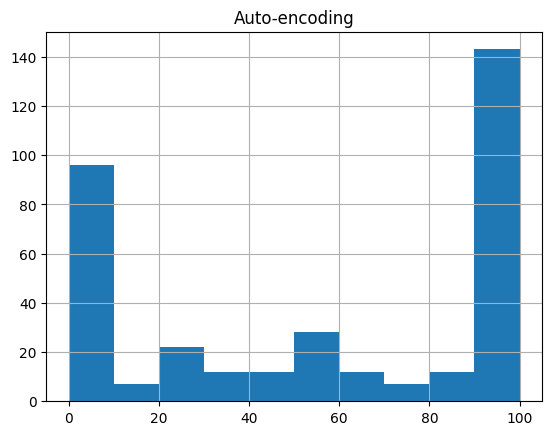

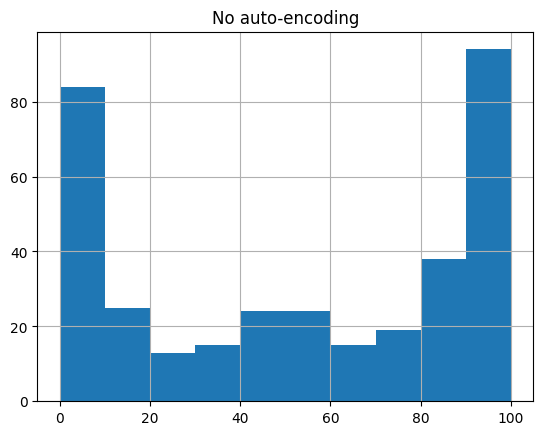

SPCA
coverage autoencoding: 270, (0.7692307692307693)
coverage no auto encoding: 301, (0.8575498575498576)
# rows added in subgroups: 12 (0.03418803418803419)
# rows no longer in subgroups: 43, (0.1225071225071225)
average subgroup size auto encoded: 187.33
average subgroup size no auto encoding: 184.63
WRACC auto encoding: Max: 0.11797793849075894, Mean: 0.10420702754036086
WRACC no auto encoding: Max: 0.1407699612827818, Mean: 0.13164511651691138


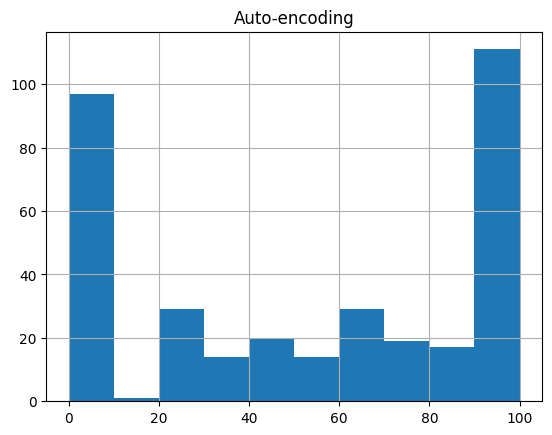

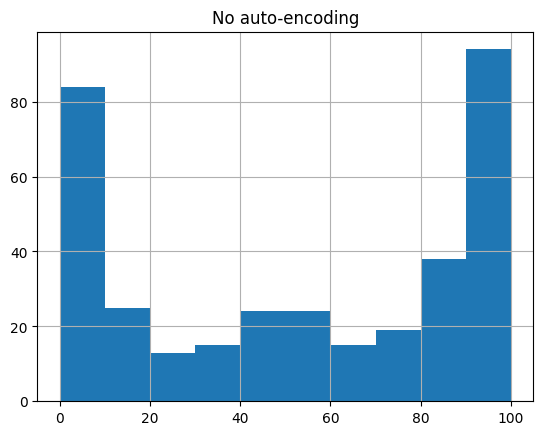

Arrhythmia :    

coverage autoencoding: 221, (0.5261904761904762)
coverage no auto encoding: 187, (0.4452380952380952)
# rows added in subgroups: 119 (0.2833333333333333)
# rows no longer in subgroups: 85, (0.20238095238095238)
average subgroup size auto encoded: 81.94
average subgroup size no auto encoding: 146.36
WRACC auto encoding: Max: 0.06547619047619048, Mean: 0.05392278911564624
WRACC no auto encoding: Max: 0.0827891156462585, Mean: 0.08085442176870748


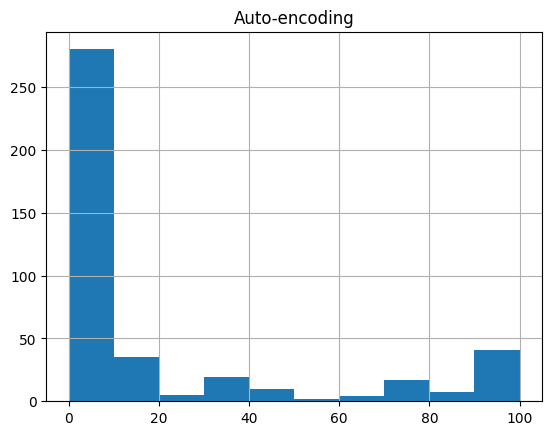

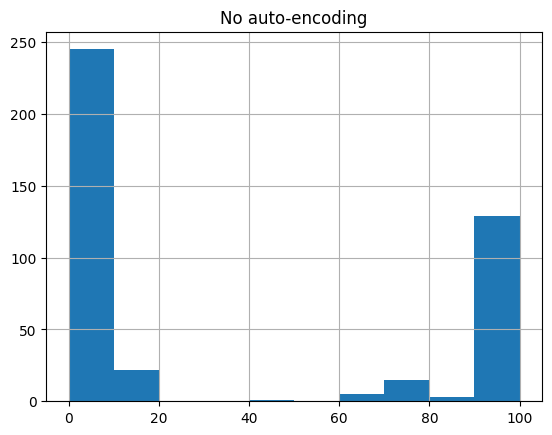

auto_encoder
coverage autoencoding: 221, (0.5261904761904762)
coverage no auto encoding: 187, (0.4452380952380952)
# rows added in subgroups: 119 (0.2833333333333333)
# rows no longer in subgroups: 85, (0.20238095238095238)
average subgroup size auto encoded: 81.94
average subgroup size no auto encoding: 146.36
WRACC auto encoding: Max: 0.06547619047619048, Mean: 0.05392278911564624
WRACC no auto encoding: Max: 0.0827891156462585, Mean: 0.08085442176870748


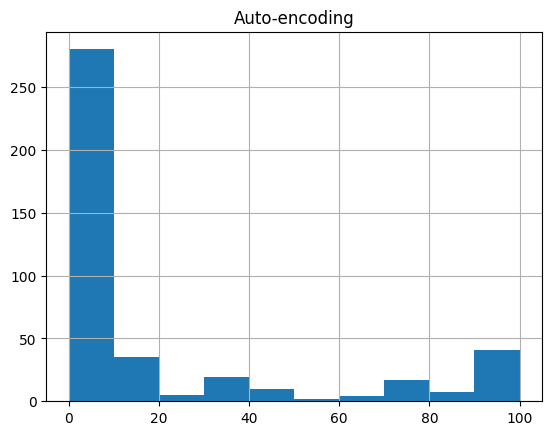

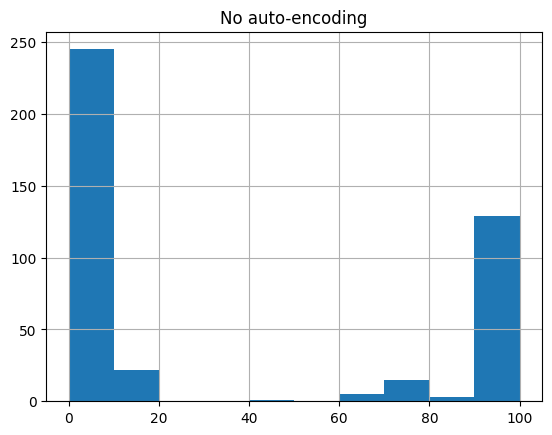

PCA
coverage autoencoding: 253, (0.6023809523809524)
coverage no auto encoding: 187, (0.4452380952380952)
# rows added in subgroups: 96 (0.22857142857142856)
# rows no longer in subgroups: 30, (0.07142857142857142)
average subgroup size auto encoded: 124.22
average subgroup size no auto encoding: 146.36
WRACC auto encoding: Max: 0.06666666666666665, Mean: 0.06179897959183672
WRACC no auto encoding: Max: 0.0827891156462585, Mean: 0.08085442176870748


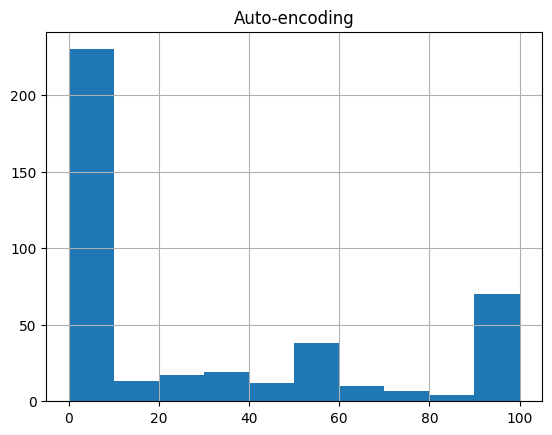

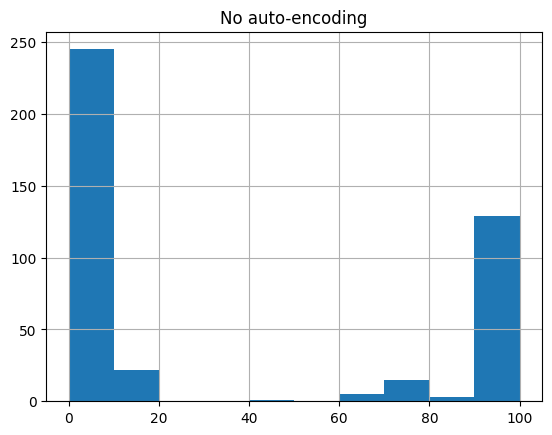

SPCA
coverage autoencoding: 210, (0.5)
coverage no auto encoding: 187, (0.4452380952380952)
# rows added in subgroups: 68 (0.1619047619047619)
# rows no longer in subgroups: 45, (0.10714285714285714)
average subgroup size auto encoded: 104.12
average subgroup size no auto encoding: 146.36
WRACC auto encoding: Max: 0.09047619047619049, Mean: 0.06629387755102042
WRACC no auto encoding: Max: 0.0827891156462585, Mean: 0.08085442176870748


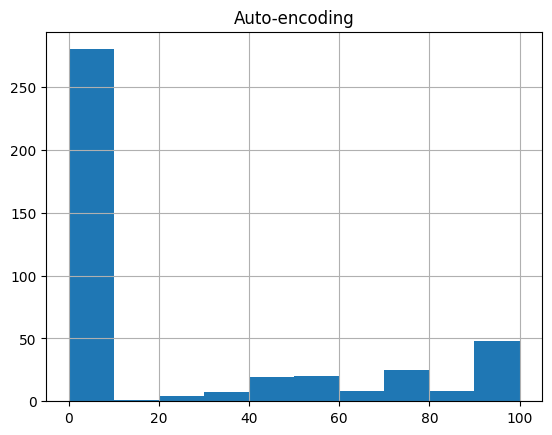

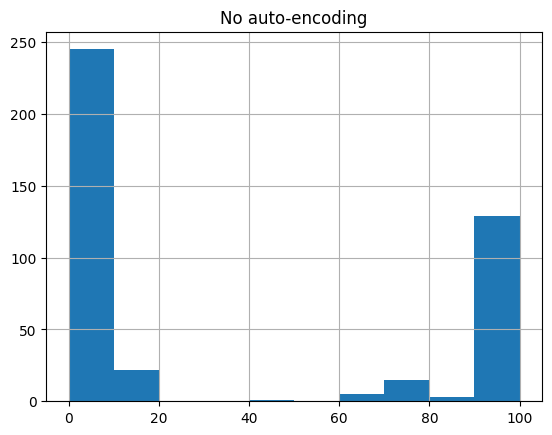

Indoor :    

coverage autoencoding: 13094, (0.6221018624097301)
coverage no auto encoding: 5553, (0.2638255416191562)
# rows added in subgroups: 7574 (0.3598441657164576)
# rows no longer in subgroups: 33, (0.0015678449258836945)
average subgroup size auto encoded: 9921.35
average subgroup size no auto encoding: 4235.05
WRACC auto encoding: Max: 0.206845412870345, Mean: 0.19404694122976912
WRACC no auto encoding: Max: 0.10803418181114251, Mean: 0.10790805699982998


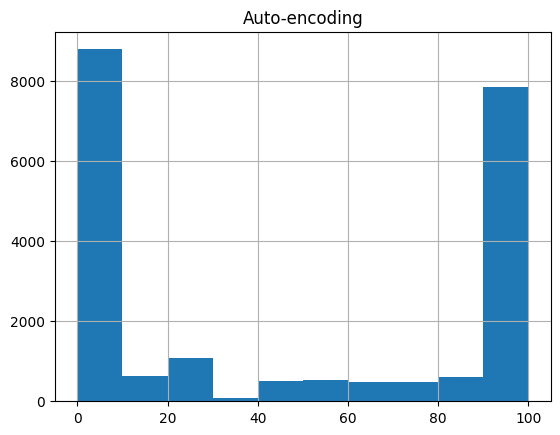

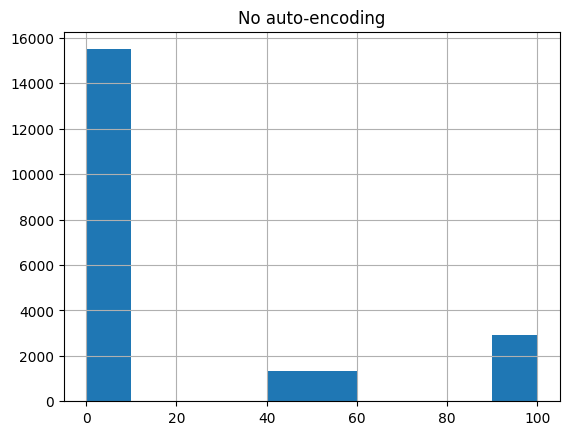

auto_encoder
coverage autoencoding: 13094, (0.6221018624097301)
coverage no auto encoding: 5553, (0.2638255416191562)
# rows added in subgroups: 7574 (0.3598441657164576)
# rows no longer in subgroups: 33, (0.0015678449258836945)
average subgroup size auto encoded: 9921.35
average subgroup size no auto encoding: 4235.05
WRACC auto encoding: Max: 0.206845412870345, Mean: 0.19404694122976912
WRACC no auto encoding: Max: 0.10803418181114251, Mean: 0.10790805699982998


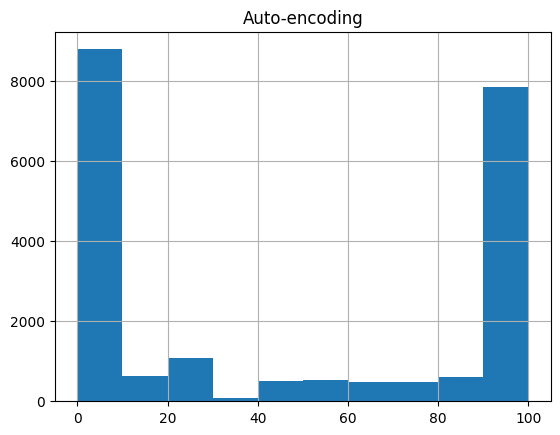

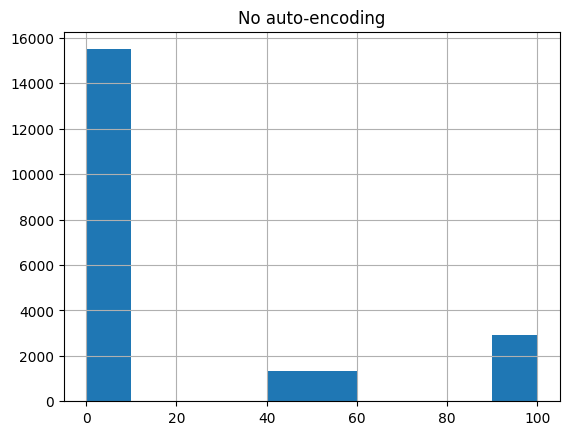

PCA
coverage autoencoding: 13176, (0.6259977194982896)
coverage no auto encoding: 5553, (0.2638255416191562)
# rows added in subgroups: 7632 (0.36259977194982895)
# rows no longer in subgroups: 9, (0.00042759407069555304)
average subgroup size auto encoded: 8953.99
average subgroup size no auto encoding: 4235.05
WRACC auto encoding: Max: 0.22244184294471048, Mean: 0.20875887493804318
WRACC no auto encoding: Max: 0.10803418181114251, Mean: 0.10790805699982998


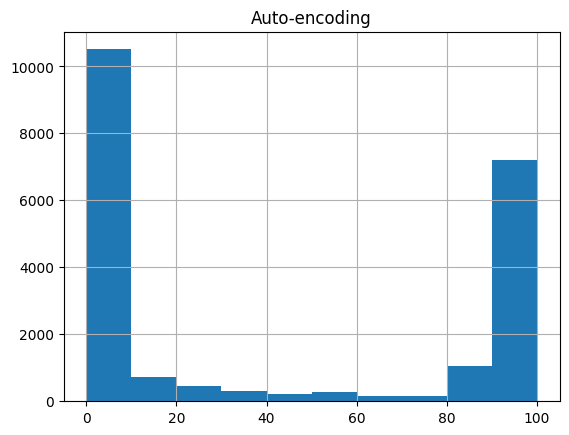

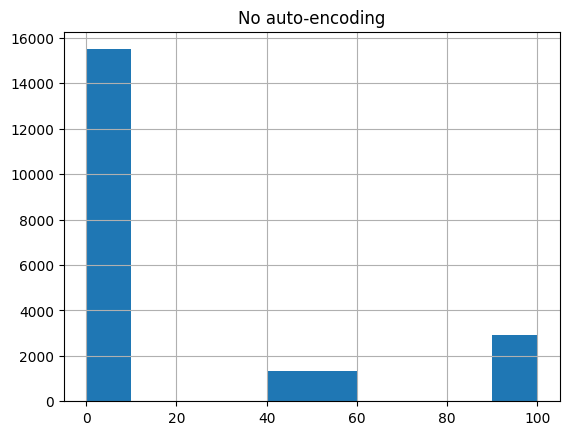

SPCA
coverage autoencoding: 14450, (0.6865260357278601)
coverage no auto encoding: 5553, (0.2638255416191562)
# rows added in subgroups: 8898 (0.4227480045610034)
# rows no longer in subgroups: 1, (4.751045229950589e-05)
average subgroup size auto encoded: 7798.87
average subgroup size no auto encoding: 4235.05
WRACC auto encoding: Max: 0.2145140982707568, Mean: 0.1799177247538738
WRACC no auto encoding: Max: 0.10803418181114251, Mean: 0.10790805699982998


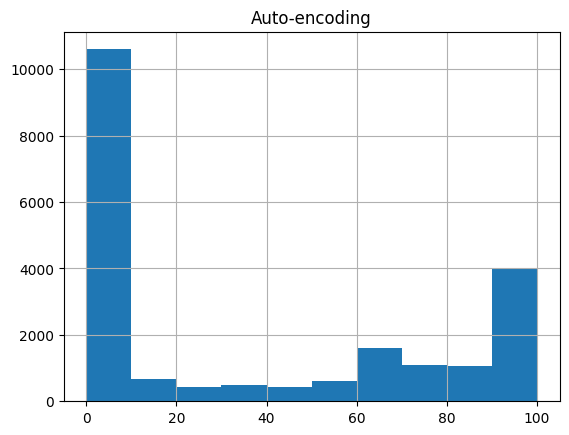

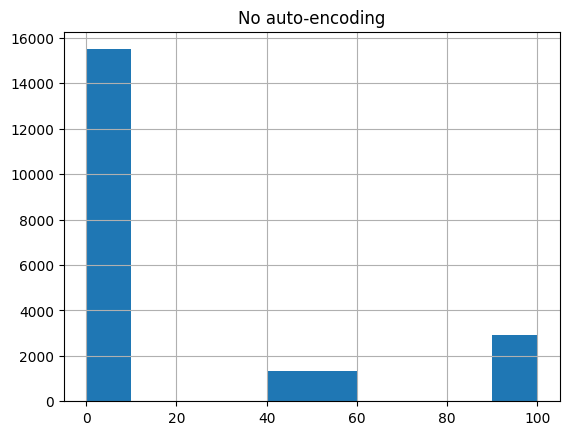

Soybean :    

coverage autoencoding: 169, (0.6353383458646616)
coverage no auto encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 97, (0.36466165413533835)
average subgroup size auto encoded: 119.06
average subgroup size no auto encoding: 266.0
WRACC auto encoding: Max: 0.19356662332523036, Mean: 0.1868149697552151
WRACC no auto encoding: Max: 0.0, Mean: 0.0


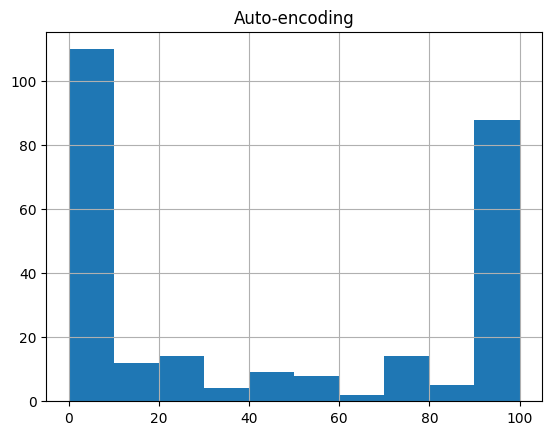

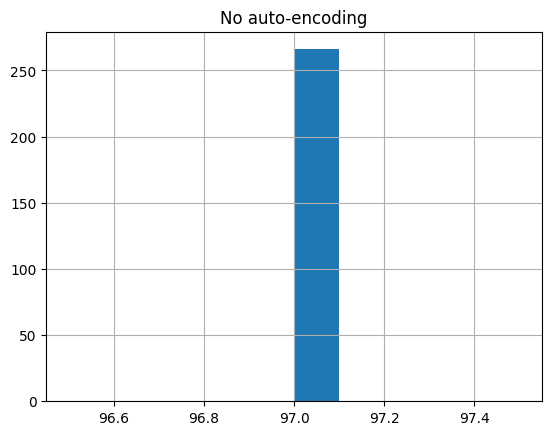

auto_encoder
coverage autoencoding: 169, (0.6353383458646616)
coverage no auto encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 97, (0.36466165413533835)
average subgroup size auto encoded: 119.06
average subgroup size no auto encoding: 266.0
WRACC auto encoding: Max: 0.19356662332523036, Mean: 0.1868149697552151
WRACC no auto encoding: Max: 0.0, Mean: 0.0


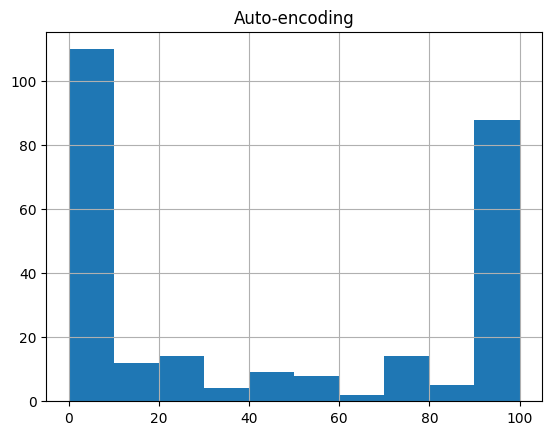

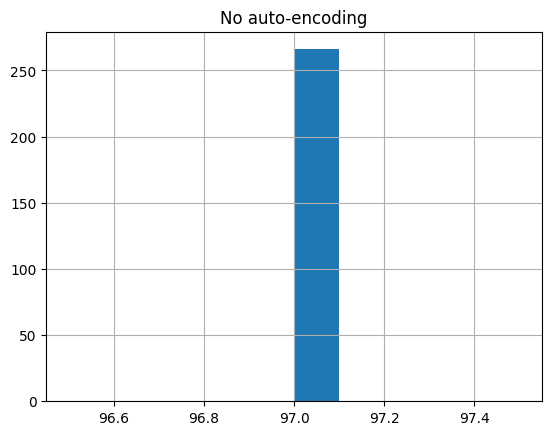

PCA
coverage autoencoding: 187, (0.7030075187969925)
coverage no auto encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 79, (0.29699248120300753)
average subgroup size auto encoded: 109.04
average subgroup size no auto encoding: 266.0
WRACC auto encoding: Max: 0.19622364181129515, Mean: 0.16300667081236928
WRACC no auto encoding: Max: 0.0, Mean: 0.0


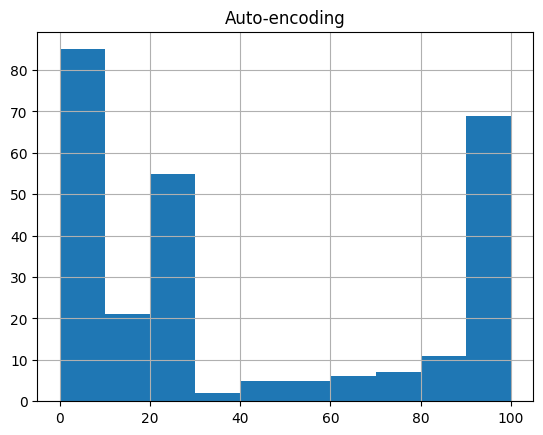

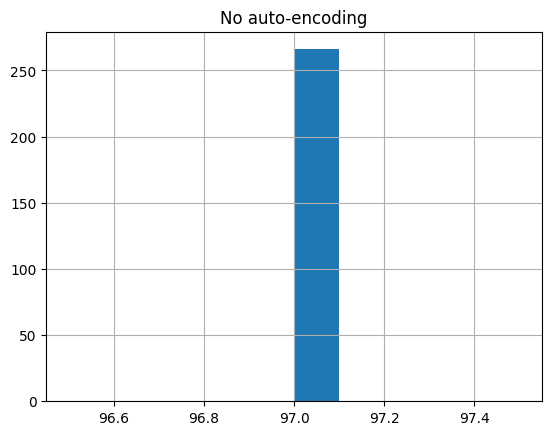

SPCA
coverage autoencoding: 152, (0.5714285714285714)
coverage no auto encoding: 266, (1.0)
# rows added in subgroups: 0 (0.0)
# rows no longer in subgroups: 114, (0.42857142857142855)
average subgroup size auto encoded: 91.01
average subgroup size no auto encoding: 266.0
WRACC auto encoding: Max: 0.20374243880377635, Mean: 0.16910311493018257
WRACC no auto encoding: Max: 0.0, Mean: 0.0


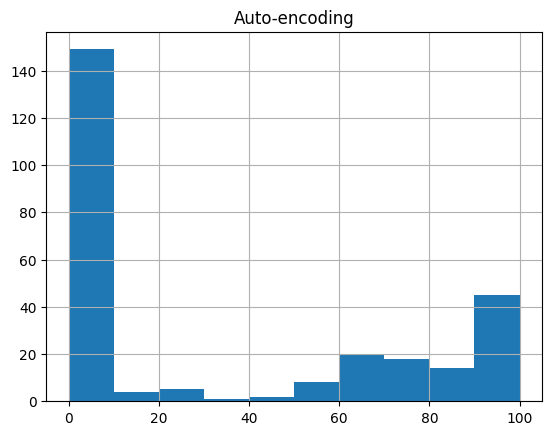

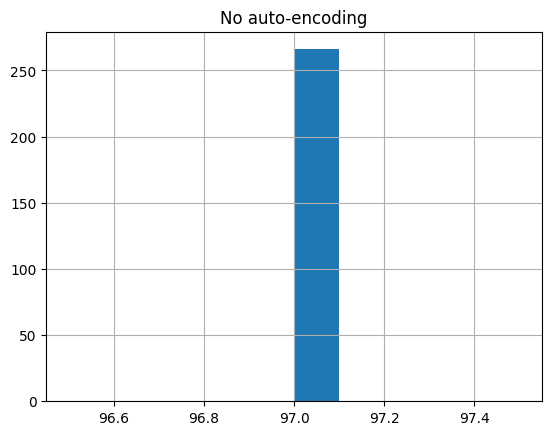

Mushroom :    

coverage autoencoding: 4429, (0.5451747907434761)
coverage no auto encoding: 4596, (0.5657311669128509)
# rows added in subgroups: 1218 (0.1499261447562777)
# rows no longer in subgroups: 1385, (0.1704825209256524)
average subgroup size auto encoded: 3241.6
average subgroup size no auto encoding: 4018.08
WRACC auto encoding: Max: 0.16271408384224723, Mean: 0.15769771399050803
WRACC no auto encoding: Max: 0.24202604582200896, Mean: 0.2260131332150777


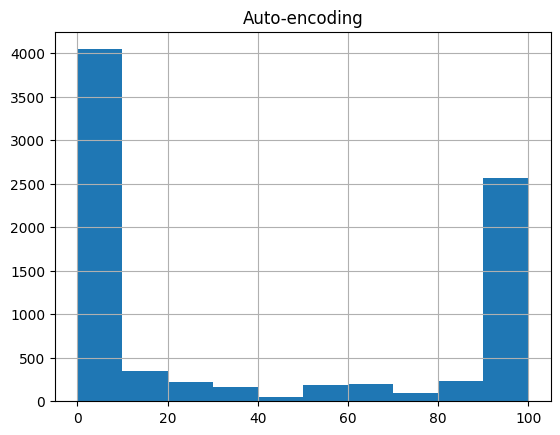

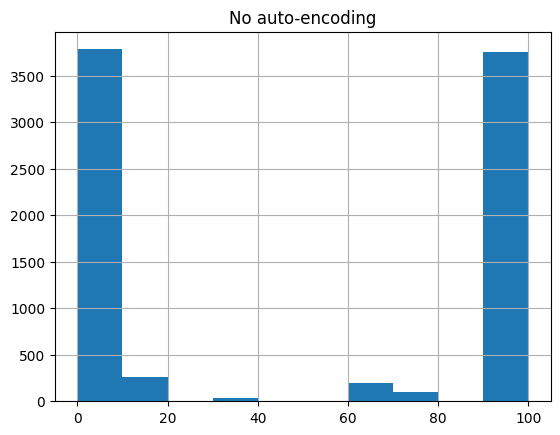

auto_encoder
coverage autoencoding: 4429, (0.5451747907434761)
coverage no auto encoding: 4596, (0.5657311669128509)
# rows added in subgroups: 1218 (0.1499261447562777)
# rows no longer in subgroups: 1385, (0.1704825209256524)
average subgroup size auto encoded: 3241.6
average subgroup size no auto encoding: 4018.08
WRACC auto encoding: Max: 0.16271408384224723, Mean: 0.15769771399050803
WRACC no auto encoding: Max: 0.24202604582200896, Mean: 0.2260131332150777


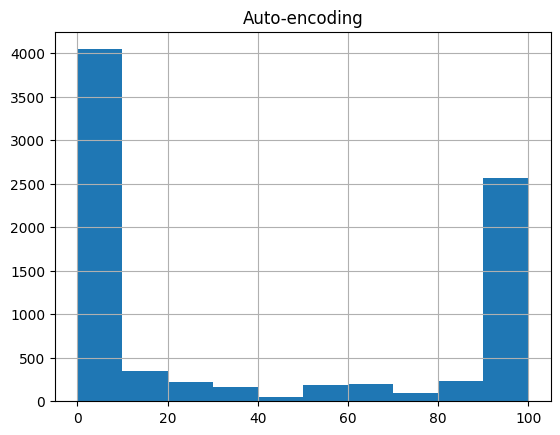

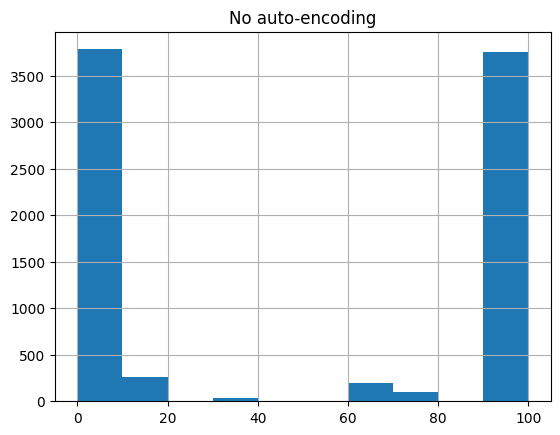

PCA
coverage autoencoding: 4835, (0.595150172328902)
coverage no auto encoding: 4596, (0.5657311669128509)
# rows added in subgroups: 891 (0.10967503692762186)
# rows no longer in subgroups: 652, (0.08025603151157065)
average subgroup size auto encoded: 3096.59
average subgroup size no auto encoding: 4018.08
WRACC auto encoding: Max: 0.19071974256241456, Mean: 0.1609681424866805
WRACC no auto encoding: Max: 0.24202604582200896, Mean: 0.2260131332150777


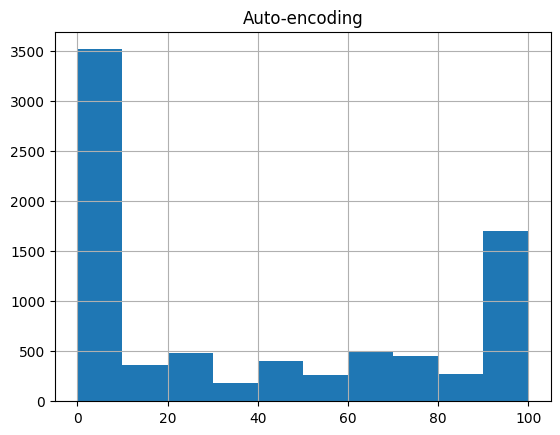

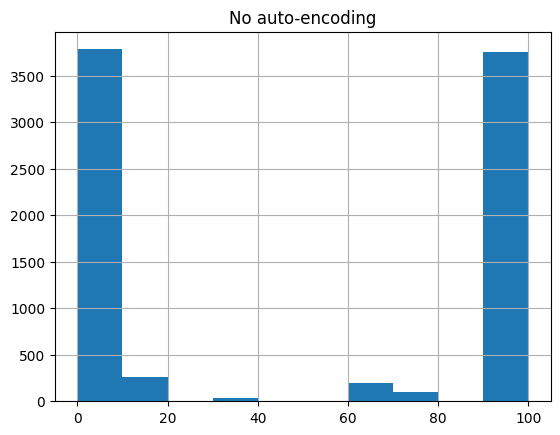

SPCA
coverage autoencoding: 4485, (0.5520679468242246)
coverage no auto encoding: 4596, (0.5657311669128509)
# rows added in subgroups: 1046 (0.12875430822255046)
# rows no longer in subgroups: 1157, (0.14241752831117677)
average subgroup size auto encoded: 2844.2
average subgroup size no auto encoding: 4018.08
WRACC auto encoding: Max: 0.19427117007894135, Mean: 0.16702786523315014
WRACC no auto encoding: Max: 0.24202604582200896, Mean: 0.2260131332150777


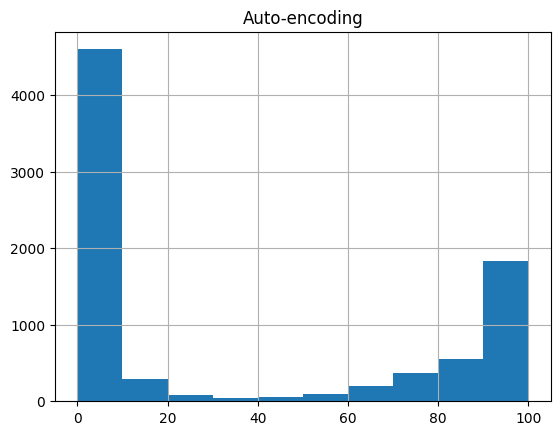

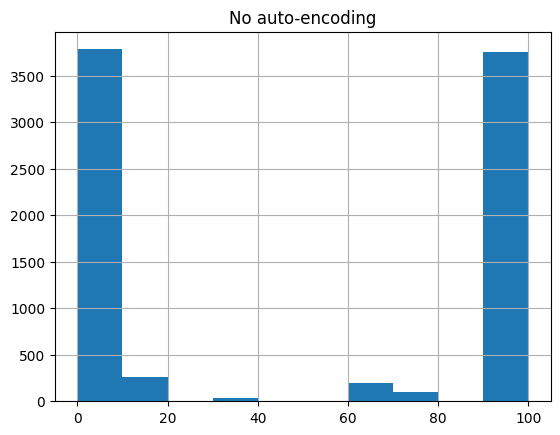

In [3]:
sd_methods = ['Beam Search']
output_dataframes = {}
for sd_method in sd_methods:
    print(sd_method, ":    \n\n")
    sd_results_path = r'C:\Users\20193723\OneDrive - TU Eindhoven\Documents\Research Topics in Data Mining\Interpretable-Subgroup-Discovery\results_renamed'
    dct_datasets = ['Ionosphere', 'Arrhythmia', 'Indoor', 'Soybean', 'Mushroom']  # to test <- Remove later
    categorical_datasets = ['Mushroom', 'Adult']
    quality_results = []
    quality_results_columns = []
    for dataset in dct_datasets:
        dataset_quality_results = []
        dataset_quality_columns = []
        #Load dataframes and results
        df_file_name = dataset+'-data-reductions.pkl'
        results_file_name = dataset+'-results.pkl'
        with open(os.path.join(sd_results_path,df_file_name), 'rb') as f:
            dfs_dict =pickle.load(f)
        with open(os.path.join(sd_results_path,results_file_name), 'rb') as f:
            results_dict =pickle.load(f)
        
        if sd_method == 'Beam Search':
            print(dataset, ":    \n")
            en_methods = ['auto_encoder', 'PCA', 'SPCA']
            subgroups_beam_en = [i for i in results_dict['auto_encoder'][sd_method]['results_org'].get_values()]
            subgroups_beam = [i for i in results_dict['vanilla'][sd_method]['results_org'].get_values()]
            output_en, output = calc_result_bs(dfs_dict['auto_encoder'], dfs_dict['vanilla'], subgroups_beam_en, subgroups_beam)
            dataset_quality_results+=output
            dataset_quality_columns += ['coverage', 'coverage_prop', 'avg_size', 'max_wracc', 'avg_wracc']
            for en_method in en_methods:
                print(en_method)
                subgroups_beam_en = [i for i in results_dict[en_method][sd_method]['results_org'].get_values()]
                subgroups_beam = [i for i in results_dict['vanilla'][sd_method]['results_org'].get_values()]
                output_en, output = calc_result_bs(dfs_dict[en_method], dfs_dict['vanilla'], subgroups_beam_en, subgroups_beam)
                dataset_quality_results+=output_en
                dataset_quality_columns += ['coverage_'+en_method, 'coverage_pop_'+en_method, 'added_'+en_method, 'added_prop_'+en_method, 'removed_'+en_method, 'removed_prop_'+en_method, 'avg_size_'+en_method, 'max_wracc_'+en_method, 'avg_wracc_'+en_method]
        
        
        if sd_method != 'Beam Search':
            print(dataset, ":    \n")
            en_methods = ['auto_encoder', 'PCA', 'SPCA']
            output_en, output = calc_result_ps(dfs_dict['auto_encoder'], dfs_dict['vanilla'], results_dict['auto_encoder'][sd_method]['results_org'], results_dict['vanilla'][sd_method]['results_org'])
            dataset_quality_results+=output
            dataset_quality_columns += ['coverage', 'coverage_prop', 'avg_size', 'max_wracc', 'avg_wracc']
            for en_method in en_methods:
                print(en_method)
                output_en, output = calc_result_ps(dfs_dict[en_method], dfs_dict['vanilla'], results_dict[en_method][sd_method]['results_org'], results_dict['vanilla'][sd_method]['results_org'])
                dataset_quality_results+=output_en
                dataset_quality_columns += ['coverage_'+en_method, 'coverage_pop_'+en_method, 'added_'+en_method, 'added_prop_'+en_method, 'removed_'+en_method, 'removed_prop_'+en_method, 'avg_size_'+en_method, 'max_wracc_'+en_method, 'avg_wracc_'+en_method]
        
        quality_results.append(dataset_quality_results)
    df = pd.DataFrame(data=quality_results, index=dct_datasets, columns=dataset_quality_columns)
    output_dataframes[sd_method] = df
    


In [3]:
calc_result_ps(dfs_dict['auto_encoder'], dfs_dict['vanilla'], results_dict['auto_encoder'][sd_method]['results_org'], results_dict['vanilla'][sd_method]['results_org'])

NameError: name 'dfs_dict' is not defined